In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.utils import plot_model
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
import pandas as pd

In [11]:
Data = pd.read_csv("/content/AAPL.csv")
Data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600
...,...,...,...,...,...,...,...
10463,2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
10464,2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
10465,2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000
10466,2022-06-16,132.080002,132.389999,129.039993,130.059998,130.059998,108123900


In [13]:
Data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [14]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [15]:
Data=Data.set_index('Date')

In [16]:
Data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


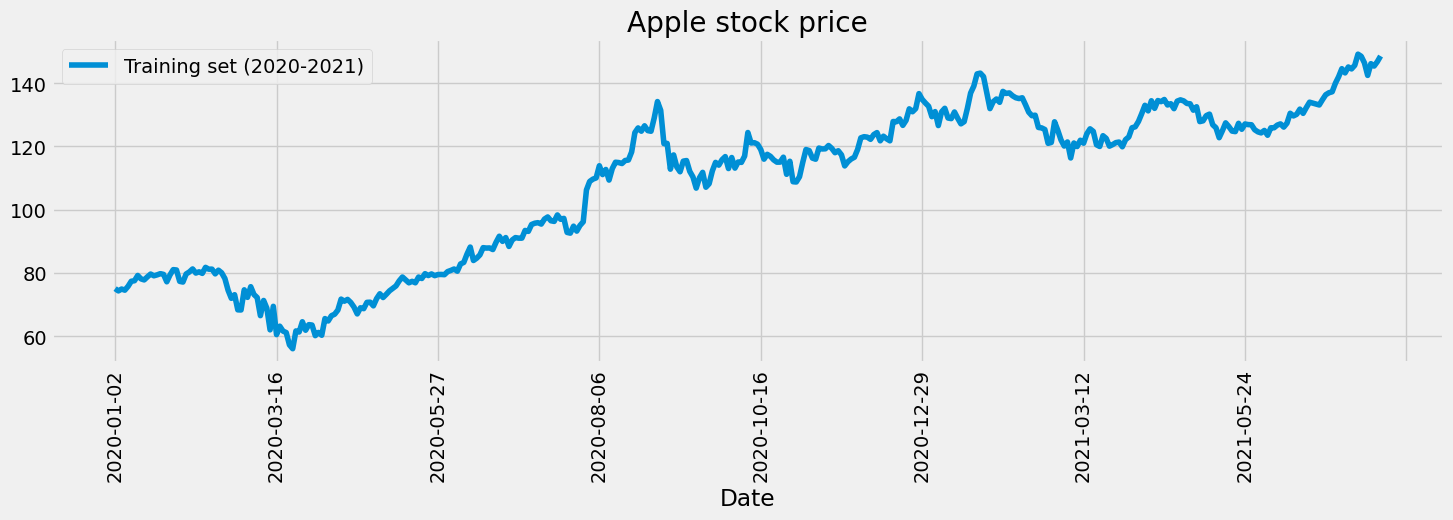

In [17]:
plt.figure(figsize=(10,5))
Data['Close']['2020':'2021-07-25'].plot(figsize=(16,4),legend=True)
plt.xticks(rotation=90)
plt.legend(['Training set (2020-2021)'])
plt.title('Apple stock price')
plt.show()

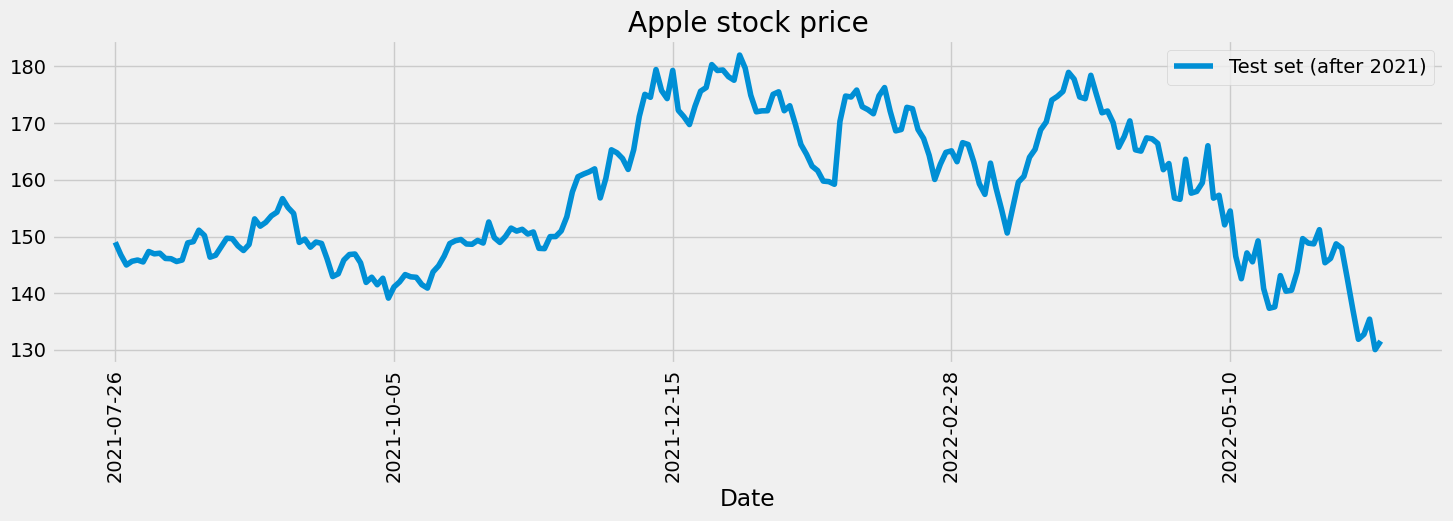

In [18]:
Data['Close']['2021-07-25':].plot(figsize=(16,4),legend=True)
plt.xticks(rotation=90)
plt.legend(['Test set (after 2021)'])
plt.title('Apple stock price')
plt.show()

In [19]:
#Extract High column data
Train_set=Data['Close']['2020-03-10':'2021-07-25'].values
Test_set=Data['Close']['2021-07-25':].values
S=MinMaxScaler()
scaled_train=S.fit_transform(Train_set.reshape(-1,1))
scaled_test=S.transform(Test_set.reshape(-1,1))

In [20]:
Test_set_to_prediction=np.concatenate([scaled_train[-21:],scaled_test],axis=0)

In [21]:
window_size = 3
def windowed_dataset(series,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series.reshape(-1,1))

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    #dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(len(series)).prefetch(1)

    return dataset

In [22]:
X,y=np.array(list(windowed_dataset(scaled_train,10))[0][0]),np.array(list(windowed_dataset(scaled_train,10))[0][1])

In [26]:
X[:5]

array([[[0.16379659],
        [0.13717325],
        [0.06410016]],

       [[0.13717325],
        [0.06410016],
        [0.14399701]],

       [[0.06410016],
        [0.14399701],
        [0.04792739]],

       [[0.14399701],
        [0.04792739],
        [0.07653871]],

       [[0.04792739],
        [0.07653871],
        [0.05990921]]])

In [28]:
y[:5]

array([[0.14399701],
       [0.04792739],
       [0.07653871],
       [0.05990921],
       [0.0548317 ]])

In [29]:
X_test,y_test=np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][0]),np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][1])

In [31]:
X_test[:5]

array([[[0.83085736],
        [0.82763352],
        [0.84557939]],

       [[0.82763352],
        [0.84557939],
        [0.86223579]],

       [[0.84557939],
        [0.86223579],
        [0.86900585]],

       [[0.86223579],
        [0.86900585],
        [0.8723371 ]],

       [[0.86900585],
        [0.8723371 ],
        [0.90124399]]])

In [48]:
Model1=Sequential(
[
    LSTM(units=60,input_shape=(X.shape[1],1),return_sequences=True),
    LSTM(units=50,activation="relu", return_sequences=True),
    LSTM(units=30,activation="relu", return_sequences=True),
    LSTM(units=20,activation="relu", return_sequences=True),
    LSTM(10),
    Dense(units=1),
])

In [52]:
Model1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

In [54]:
callbacks=tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        mode='max',
        patience=10,
        verbose=1
    )
history=Model1.fit(X,y,epochs=300,callbacks=[callbacks])

Epoch 1/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0297 - mae: 0.0297
Epoch 2/300
11/11 [==============================] - 0s 14ms/step - loss: 0.0273 - mae: 0.0273
Epoch 3/300
11/11 [==============================] - 0s 12ms/step - loss: 0.0289 - mae: 0.0289
Epoch 4/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0276 - mae: 0.0276
Epoch 5/300
11/11 [==============================] - 0s 14ms/step - loss: 0.0290 - mae: 0.0290
Epoch 6/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0283 - mae: 0.0283
Epoch 7/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0281 - mae: 0.0281
Epoch 8/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0288 - mae: 0.0288
Epoch 9/300
11/11 [==============================] - 0s 13ms/step - loss: 0.0289 - mae: 0.0289
Epoch 10/300
11/11 [==============================] - 0s 12ms/step - loss: 0.0289 - mae: 0.0289
Epoch 11/300
11/11 [=============================

In [55]:
Model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 3, 60)             14880     
                                                                 
 lstm_11 (LSTM)              (None, 3, 50)             22200     
                                                                 
 lstm_12 (LSTM)              (None, 3, 30)             9720      
                                                                 
 lstm_13 (LSTM)              (None, 3, 20)             4080      
                                                                 
 lstm_14 (LSTM)              (None, 10)                1240      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 52131 (203.64 KB)
Trainable params: 5213

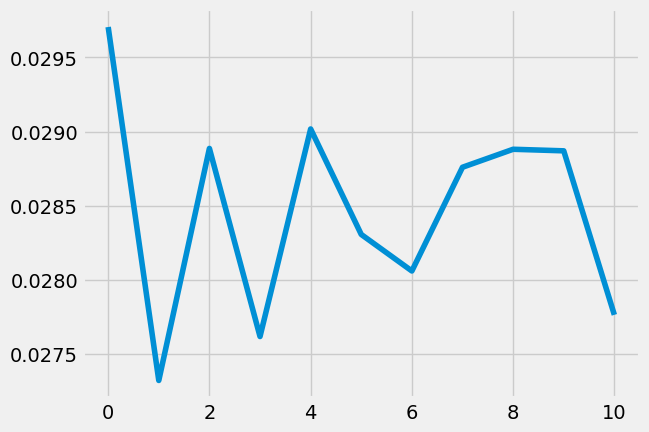

In [56]:
plt.plot(history.history['loss'])

In [57]:
Output1=Model1.predict(X_test)

8/8 [==============================] - 2s 8ms/step


In [58]:
Model1.evaluate(y_test,Output1)

8/8 [==============================] - 1s 4ms/step - loss: 0.9913 - mae: 0.9913


[0.9912835359573364, 0.9912835359573364]

In [59]:
mean_squared_error(S.inverse_transform(y_test),S.inverse_transform(Output1))

56.481228323289024

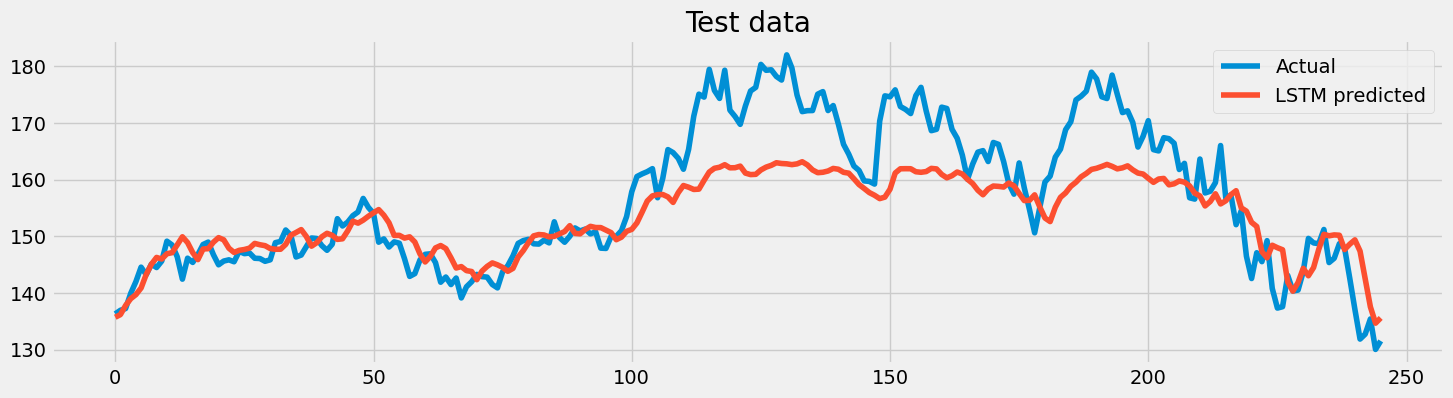

In [60]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.title("Test data",fontsize=20)
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(Output1),label="LSTM predicted")
plt.legend()
plt.show()

In [61]:
Out=Model1.predict(X)

11/11 [==============================] - 0s 7ms/step


In [65]:
Out[:5]

array([[0.154362  ],
       [0.12862454],
       [0.10481373],
       [0.12374816],
       [0.08477404]], dtype=float32)

In [66]:
y[:5]

array([[0.14399701],
       [0.04792739],
       [0.07653871],
       [0.05990921],
       [0.0548317 ]])

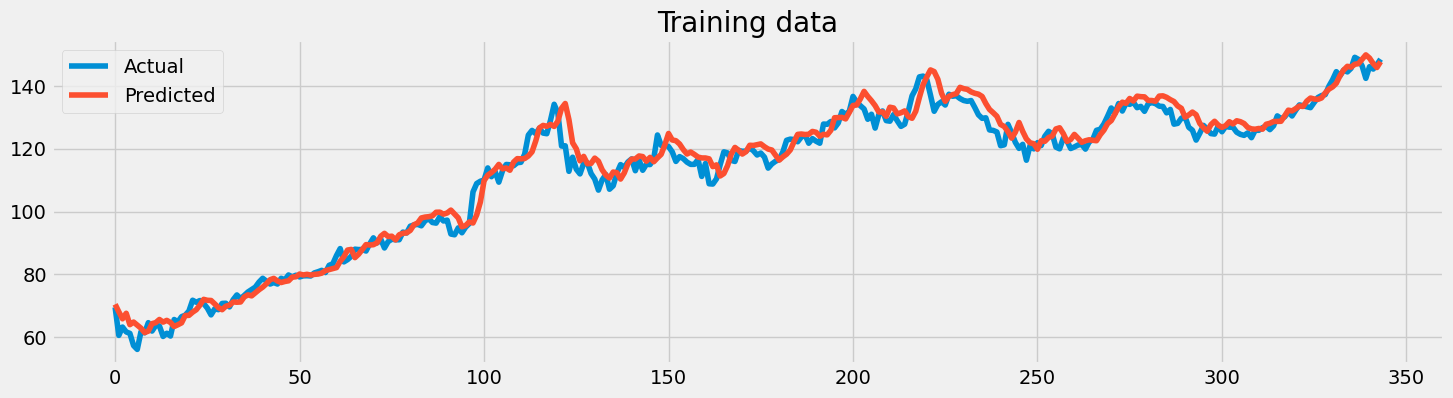

In [62]:
q=np.arange(0,len(y))
plt.figure(figsize=(16,4))
plt.title("Training data",fontsize=20)
plt.plot(q,S.inverse_transform(y),label='Actual')
plt.plot(q,S.inverse_transform(Out),label='Predicted')
plt.legend()
plt.show()

In [63]:
Model1.save("out/forcasting_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
